In [1]:
# MorseEncoder.py  - Morse Encoder to generate training material for neural networks
# Generates raw signal waveforms with Gaussian noise and QSB (signal fading) effects
# Provides also the training target variables in separate columns. 
#
# WPM= 40 # speed 40 words per minute
# Tq = 4. # QSB cycle time in seconds (typically 5..10 secs)
# sigma = 0.02 # add some Gaussian noise
# padded = if True then pad all characters to 32 dits long
# 
# Example usage:
# P = signal('QUICK BROWN FOX JUMPED OVER THE LAZY FOX ',WPM,Tq,sigma,padded)
# from matplotlib.pyplot import  plot,show,figure,legend
# from numpy.random import normal
# figure(figsize=(12,3))
# lb1,=plot(P.t,P.sig,'b',label="sig")
# lb2,=plot(P.t,P.dit,'g',label="dit")
# lb3,=plot(P.t,P.dah,'g',label="dah")
# lb4,=plot(P.t,P.ele,'m',label="ele")
# lb5,=plot(P.t,P.chr,'c',label="chr")
# lb6,=plot(P.t,P.wrd,'r*',label="wrd")
# legend([lb1,lb2,lb3,lb4,lb5,lb6])
# show()
# P.to_csv("MorseTest.csv")
#
# Copyright (C) 2015   Mauri Niininen, AG1LE
#
#
# MorseEncoder.py is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# MorseEncoder.py is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with bmorse.py.  If not, see <http://www.gnu.org/licenses/>.

import numpy as np
import pandas as pd
from numpy import sin,pi
from numpy.random import normal
pd.options.mode.chained_assignment = None  #to prevent warning messages

Morsecode = {
 '!': '-.-.--',
 '$': '...-..-',
 "'": '.----.',
 '(': '-.--.',
 ')': '-.--.-',
 ',': '--..--',
 '-': '-....-',
 '.': '.-.-.-',
 '/': '-..-.',
 '0': '-----',
 '1': '.----',
 '2': '..---',
 '3': '...--',
 '4': '....-',
 '5': '.....',
 '6': '-....',
 '7': '--...',
 '8': '---..',
 '9': '----.',
 ':': '---...',
 ';': '-.-.-.',
 '<AR>': '.-.-.',
 '<AS>': '.-...',
 '<HM>': '....--',
 '<INT>': '..-.-',
 '<SK>': '...-.-',
 '<VE>': '...-.',
 '=': '-...-',
 '?': '..--..',
 '@': '.--.-.',
 'A': '.-',
 'B': '-...',
 'C': '-.-.',
 'D': '-..',
 'E': '.',
 'F': '..-.',
 'G': '--.',
 'H': '....',
 'I': '..',
 'J': '.---',
 'K': '-.-',
 'L': '.-..',
 'M': '--',
 'N': '-.',
 'O': '---',
 'P': '.--.',
 'Q': '--.-',
 'R': '.-.',
 'S': '...',
 'T': '-',
 'U': '..-',
 'V': '...-',
 'W': '.--',
 'X': '-..-',
 'Y': '-.--',
 'Z': '--..',
 '\\': '.-..-.',
 '_': '..--.-',
 '~': '.-.-',
 ' ': '_'}
    

def encode_morse(cws):
    s=[]
    for chr in cws:
        try: # try to find CW sequence from Codebook
            s += Morsecode[chr]
            if chr != ' ':
                s += ' '
        except:
            if chr == ' ' or chr =='\n':
                s += '_'
                continue
            print "error: %s not in Codebook" % chr
    return ''.join(s)

def len_chr(ch):
    s = Morsecode[ch]
    return len_dits(s)

def len_dits(cws):
    # length of string in dit units, include spaces
    val = 0
    for ch in cws:
        if ch == '.': # dit len + el space 
            val += 2
        if ch == '-': # dah len + el space
            val += 4
        if ch==' ':   #  el space
            val += 2
        if ch=='_':   #  el space
            val += 7
    return val


def signal(cw_str,WPM,Tq,sigma,padded):
    # for given CW string i.e. 'ABC ' 
    # return a pandas dataframe with signals and  symbol probabilities
    # WPM = Morse speed in Words Per Minute (typically 5...50)
    # Tq  = QSB cycle time (typically 3...10 seconds) 
    # sigma = adds gaussian noise with standard deviation of sigma to signal
    cws = encode_morse(cw_str)
    #print cws
    # calculate how many milliseconds this string will take at speed WPM
    ditlen = 1200/WPM # dit length in msec, given WPM
    #msec = ditlen*(len_dits(cws)+7)  # reserve +7 for the last pause
    msec = ditlen*len(cw_str)*32+7
    t = np.arange(msec)/ 1000.       # time array in seconds
    ix = range(0,msec)               # index for arrays

    # Create a DataFrame and initialize
    col =["t","sig","dit","dah","ele","chr","wrd","spd"]
    P = pd.DataFrame(index=ix,columns=col)
    P.t = t              # keep time  
    P.sig=np.zeros(msec) # signal stored here
    P.dit=np.zeros(msec) # probability of 'dit' stored here
    P.dah=np.zeros(msec) # probability of 'dah' stored here
    P.ele=np.zeros(msec) # probability of 'element space' stored here
    P.chr=np.zeros(msec) # probability of 'character space' stored here
    P.wrd=np.zeros(msec) # probability of 'word space' stored here
    P.spd=np.ones(msec)*WPM #speed stored here 

    
    #pre-made arrays with multiple(s) of ditlen
    z = np.zeros(ditlen) 
    z2 = np.zeros(2*ditlen)
    z4 = np.zeros(4*ditlen)
    dit = np.ones(ditlen)
    dah = np.ones(3*ditlen)
      
    # For all dits/dahs in CW string generate the signal, update symbol probabilities
    # Note: this is very slow in Python and can be optimized a lot 
    i = 0
    n = 0  #counter for elements until ' ' or '_' 
    for ch in cws:
        prct=100.0*float(i)/float(msec)
        if (i % 1000) == 0: 
            print "Done: " + "{:.6f}".format(prct)+ "%"
        if ch == '.':
            dur = len(dit)
            P.sig[i:i+dur] = dit
            P.dit[i:i+dur] = dit
            i += dur
            n += dur
            dur=len(z)
            P.sig[i:i+dur] = z
            P.ele[i:i+dur] = np.ones(dur)
            i += dur
            n += dur

        if ch == '-':
            dur = len(dah)
            P.sig[i:i+dur] = dah
            P.dah[i:i+dur]=  dah
            i += dur
            n += dur            
            dur=len(z)
            P.sig[i:i+dur] = z
            P.ele[i:i+dur] = np.ones(dur)
            i += dur
            n += dur
            
        if ch == ' ':
            dur = len(z2)
            P.sig[i:i+dur] = z2
            P.chr[i:i+dur]=  np.ones(dur)
            i += dur
            n += dur
            if (padded):
                fil = 32 - n
                #print 'i:fil:n',i,fil,n
                for j in range(fil):
                    dur = len(z)
                    #print 'j:i:dur',j,i,dur
                    P.sig[i:i+dur] = z
                    P.chr[i:i+dur]=  np.ones(dur)
                    i += dur
            n = 0

        if ch == '_':
            dur = len(z4)
            P.sig[i:i+dur] = z4
            P.wrd[i:i+dur]=  np.ones(dur)
            i += dur
            n += dur
            if (padded):
                fil = 32 - n
                #print 'i:fil:n',i,fil,n
                for j in range(fil):
                    dur = len(z)
                    #print 'j:i:dur',j,i,dur
                    P.sig[i:i+dur] = z
                    P.chr[i:i+dur]=  np.ones(dur)
                    i += dur
            n = 0
                
    if Tq > 0.:  # QSB cycle time impacts signal amplitude
        qsb = 0.5 * sin((1./float(Tq))*t*2*pi) +0.55
        P.sig = qsb*P.sig
    if sigma >0.:
        P.sig += normal(0,sigma,len(P.sig))
    return P



In [ ]:
# Open a sample training material text file 
f = open('arrl2.txt','r')
txt = f.read()
print "Training text length:%d",len(txt) 

In [ ]:
# Create a training signal file 
a=signal(txt,1200,0,0,True)
a.to_pickle('arrl2_padded.pkl')

In [2]:
# Read the text and training files, create suitable formatted vectors for RNN training 
import pandas as pd
f = open('arrl2.txt','r')
txt = f.read()
a = pd.read_pickle('arrl2_padded.pkl')

xs = a[["sig"]].as_matrix()
ys = a[["dit","dah","ele","chr","wrd"]].as_matrix()

print len(xs), len(ys)

4963399 4963399


(155106, 32) (155106, 60) 155106 155106
['N', 'O', 'W', ' ', '2', '0', ' ', 'W', 'P', 'M', ' ', 'T', 'E', 'X', 'T', ' ', 'I', 'S', ' ', 'F', 'R', 'O', 'M', ' ', 'J', 'A', 'N', 'U', 'A', 'R', 'Y', ' ', '2', '0', '1', '5', ' ', 'Q', 'S', 'T', ' ', ' ', 'P', 'A', 'G', 'E', ' ', '5', '6', ' ']
(155106, 32) (155106, 60)


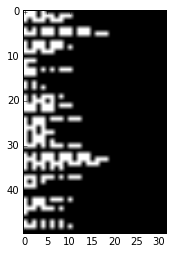

In [3]:
# Some helper functions to use 'one_hot' encoding for labels 
num_classes = len(Morsecode)
label = np.zeros(num_classes)
num_labels = len(txt)

def one_hot(ch):
    label = np.zeros(num_classes)
    try:
        e = list(Morsecode.keys()).index(ch)
        label[e] = 1
        return label
    except:
        return label

def one_hot_labels(txt):
    a = []
    for ch in txt:
        a.append(one_hot(ch))
    return a

def print_label(ys):
    s = []
    for i in range(len(ys)):
        c=ys[i:i+1].argmax()
        if c ==0:
            s += ' '
        else:
            s += list(Morsecode.keys())[c]
    return s


ys = np.asarray(one_hot_labels(txt)).astype(np.float32)
xs = xs[:32*num_labels].astype(np.float32)
xs = xs.reshape(num_labels,32)
print xs.shape, ys.shape, len(txt),len(xs)

# plot 50 first Morse code lines (32 pix each ) and print 50 first one_hot encoded labels
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
im = xs[:50].reshape(50,32)
plt.imshow(im,cmap = cm.Greys_r)
print print_label(ys[:50])
print xs.shape, ys.shape

In [4]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is adapted from example using MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
Adapted by: Mauri Niininen (AG1LE)

To classify Morse using a recurrent neural network, we consider every xs row as a sequence of dits & dahs 
encoded as follows:  dit = 1,0  and dah = 1,1,1,0  padded to 32 numbers
for example 'A' = [1,0,1,1,1,0,0 ... 0]
Labels are encoded with one_hot method in vector of 59 numbers. 
for example 'A' = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
xs.shape (22158, 32)  - holds 22158 training vectors
ys.shape (22158, 59)  - holds 22158 training labels 
'''
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell
import numpy as np

# Setup the model & parameters 
print "Setting up the model"
# Parameters
learning_rate = 0.001 
training_iters = 114000 #was 100000
batch_size = 126
display_step = 10

# Network Parameters
n_input = 1 # each Morse element is normalized to dit length 1 
n_steps = 32 # timesteps (training material padded to 32 dit length)
n_hidden = 128 # hidden layer num of features = 128
n_classes = 60 # Morse character set -  total classes 59 (26 letters+10 nums+ special chars)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
istate = tf.placeholder("float", [None, 2*n_hidden]) #state & cell => 2x n_hidden
y = tf.placeholder("float", [None, n_classes])
y_hat = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def RNN(_X, _istate, _weights, _biases):

    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, _X, initial_state=_istate)

    # Linear activation
    # Get inner loop last output
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']

pred = RNN(x, istate, weights, biases)

y_hat = tf.argmax(pred,1)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.types.float32))

# Initializing the variables
init = tf.initialize_all_variables()
acc=[]
loss=[]

# Saving model 
saver = tf.train.Saver()  # defaults to saving all variables - in this case w and b


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 0
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        # get batch of data 
        batch_xs = xs[batch_size*step:batch_size*(step+1)]
        batch_ys = ys[batch_size*step:batch_size*(step+1)] 
        # Reshape xs data to get 32 seq of 1 elements
        batch_xs = batch_xs.reshape((batch_size, n_steps, n_input))

        # Fit training using batch of data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys,
                                       istate: np.zeros((batch_size, 2*n_hidden))})
        if step % display_step == 0:
            # Calculate batch accuracy
            ac = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys,
                                                istate: np.zeros((batch_size, 2*n_hidden))})
            acc.append(ac)
            # Calculate batch loss
            ls = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys,
                                             istate: np.zeros((batch_size, 2*n_hidden))})
            loss.append(ls)
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(ls) + ", Training Accuracy= " + "{:.5f}".format(ac)
        step += 1
    print "Saving model checkpoint"
    saver.save(sess, 'model.ckpt', global_step=step+1)

    print "Optimization Finished!"

Setting up the model
Iter 0, Minibatch Loss= 6.967289, Training Accuracy= 0.02381
Iter 1260, Minibatch Loss= 3.432342, Training Accuracy= 0.18254
Iter 2520, Minibatch Loss= 3.036186, Training Accuracy= 0.26190
Iter 3780, Minibatch Loss= 3.054259, Training Accuracy= 0.23016
Iter 5040, Minibatch Loss= 2.987055, Training Accuracy= 0.25397
Iter 6300, Minibatch Loss= 2.998223, Training Accuracy= 0.22222
Iter 7560, Minibatch Loss= 3.059447, Training Accuracy= 0.20635
Iter 8820, Minibatch Loss= 2.875863, Training Accuracy= 0.35714
Iter 10080, Minibatch Loss= 2.696364, Training Accuracy= 0.23810
Iter 11340, Minibatch Loss= 2.480187, Training Accuracy= 0.33333
Iter 12600, Minibatch Loss= 2.273789, Training Accuracy= 0.43651
Iter 13860, Minibatch Loss= 2.184948, Training Accuracy= 0.35714
Iter 15120, Minibatch Loss= 2.363494, Training Accuracy= 0.30159
Iter 16380, Minibatch Loss= 2.150433, Training Accuracy= 0.24603
Iter 17640, Minibatch Loss= 2.387658, Training Accuracy= 0.41270
Iter 18900, Min

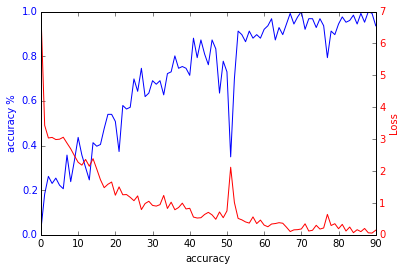

In [5]:

# plot resulting loss/accuracy curves
plt.figure(figsize=(12,6))
fig, ax1 = plt.subplots()
ax1.plot(acc, 'b')
ax1.set_xlabel('accuracy')
ax1.set_ylabel('accuracy %', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(loss, 'r')
ax2.set_ylabel('Loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

In [6]:
y_hat = tf.cast(tf.argmax(pred,1), tf.types.float32)

# create a test input from string
ts_str = "QUICK BROWN FOX JUMPED OVER THE LAZY FOX 0123456789"
ts=signal(ts_str,1200,0,0.02,True)
xs = ts[["sig"]].as_matrix()
bs = xs.shape[0]/32
xs = xs[0:bs*32]
ys = np.zeros((bs,n_classes))

# uncomment next 2 lines to create one tes character
#bs =1 
#xs = np.array([1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],dtype=float)
batch_xs =xs.reshape((bs,32,1))
print bs, ys.shape,xs.shape,batch_xs.shape

# load the model and predict label based on test input
predict = []
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('.')
    saver.restore(sess, ckpt.model_checkpoint_path)
    for i in range(bs):
        pr = sess.run(y_hat, feed_dict={x: batch_xs[i:i+1].reshape((1,32,1)), y: ys,
                                         istate: np.zeros((1, 2*n_hidden))})
        predict += (Morsecode.keys()[int(pr[0])])
    print "Prediction:",predict
    #print "Labels: \n", print_label(batch_ys)

Done: 0.000000%
51 (51, 60) (1632, 1) (51, 32, 1)
Prediction: ['Q', 'U', 'I', 'C', 'K', ' ', 'B', 'R', 'O', 'W', 'N', ' ', 'V', 'O', 'C', ' ', 'Y', 'U', 'M', 'P', 'E', 'D', ' ', 'O', 'V', 'E', 'R', ' ', 'T', 'H', 'E', ' ', 'L', 'A', 'C', 'Y', ' ', 'F', 'O', 'C', ' ', '0', '1', '2', 'P', '4', '5', 'W', 'O', 'Q', '.']
